In [1]:
## Name: Chang Liu (cliu8)
## HW2 Exercise 1


# load in the data
import pandas as pd

# Read a CSV file (assuming numeric values only)
data = pd.read_csv("./classification.csv", header = 0) 
# (a) preview the data
print(data.shape, data.iloc[:, -1].value_counts())
data[:2]


(673, 9) Label
0    429
1    244
Name: count, dtype: int64


,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,1
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,1


## (b) Query by committee

In [7]:
# (b) query by committee
# X is feature, y is label
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

SEED_LIST = range(10)  # 10 different seeds for different data initialization


import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import cdist
from scipy.stats import entropy

# Function to initialize training & testing sets
def initialize_data(seed, initial_prob):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_idx = int(initial_prob * len(X))
    train_idx, pool_idx = indices[:split_idx], indices[split_idx:]
    return train_idx, pool_idx

# Function to train random forest & compute accuracy
def evaluate_model(train_X, train_y, model):
    scores = cross_val_score(model, train_X, train_y, cv=5, scoring='accuracy')
    return np.mean(scores)


# QBC
class QueryByCommittee:
    def __init__(self, forest, n_committee=5):
        # forest: a trained RandomForestClassifier
        # n_committee: number of trees to use in the committee (default: 5)
        self.n_committee = n_committee
        self.model = forest
    
    def select_instance(self, X_pool):
        # i use soft vote by KL divergence
        # Parameters:
        # X_pool: pool of unlabeled instances (numpy array or DataFrame)

        # Returns:
        # - Index of the selected instance in X_pool

        # select n_committee estimators from the forest
        committee = self.model.estimators_[:5]

        # Get predictions from each tree in the committee
        committee_preds = np.array([tree.predict_proba(X_pool) for tree in committee])  # shape: (n_committee, n_samples)

        # Compute KL divergence of each sample, and select the index with the highest KL divergence (highest disagreement)
        consensus_probs = np.mean(committee_preds, axis=0)
        kl_scores = np.zeros(X_pool.shape[0])

        # compute the average KL divergence from the consensus for each sample
        for i in range(X_pool.shape[0]):
            sample_kl = 0.0
            for j in range(self.n_committee):
                # p is the prediction probability distribution from the j-th tree for sample i.
                p = committee_preds[j, i]
                sample_kl += entropy(p, consensus_probs[i])
            kl_scores[i] = sample_kl / self.n_committee
        
        # Select the sample with the highest average KL divergence.
        query_index = np.argmax(kl_scores)


        # Average KL divergence per sample

        return query_index
    

# Running Simulation
def run_simulation(X, y, method, seeds=SEED_LIST):
    seed_scores = []
    
    for seed in seeds:
        train_idx, pool_idx = initialize_data(seed, 0.2) # 20% of data as initial training set
        train_X, train_y = X[train_idx], y[train_idx]
        pool_X, pool_y = X[pool_idx], y[pool_idx]
        
        forest = RandomForestClassifier(n_estimators=50, random_state=seed)
        forest.fit(train_X, train_y)
        cv_scores = []
        
        for _ in range(len(pool_X)):

            score = evaluate_model(train_X, train_y, forest)
            cv_scores.append(score)
            
            
            query = QueryByCommittee(forest)
            query_idx = query.select_instance(pool_X)
            train_X = np.vstack([train_X, pool_X[query_idx]])
            train_y = np.append(train_y, pool_y[query_idx])
            pool_X = np.delete(pool_X, query_idx, axis=0)
            pool_y = np.delete(pool_y, query_idx, axis=0)
            
            forest.fit(train_X, train_y)  # Retrain the random forest with the new data point
        seed_scores.append(cv_scores)
        print(f"This is seed {seed}.")
    # store mean and std of cv results
    seed_scores = np.array(seed_scores)
    mean = np.mean(seed_scores, axis=0)
    std = np.std(seed_scores, axis=0)
    
    return mean, std


This is seed 0.
This is seed 1.
This is seed 2.
This is seed 3.
This is seed 4.
This is seed 5.
This is seed 6.
This is seed 7.
This is seed 8.
This is seed 9.


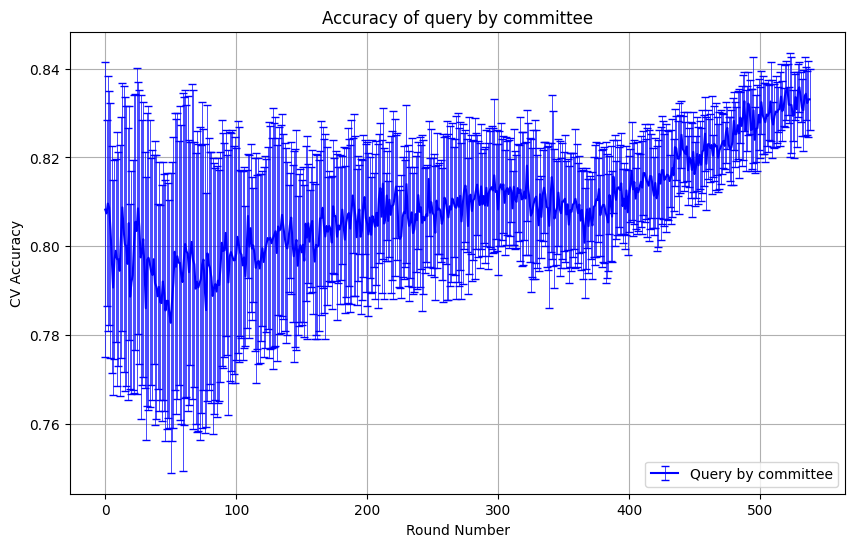

In [8]:
# run simulator for query by committee
train_mean, train_std = run_simulation(X, y, "QBC")
# plot the figure for the training set accuray visualization
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(train_mean)), train_mean, yerr=train_std, label='Query by committee', 
            color='b', capsize=3, elinewidth=0.5, capthick=1)

plt.xlabel('Round Number')
plt.ylabel('CV Accuracy')
plt.title('Accuracy of query by committee')
plt.legend()
plt.grid(True)
plt.show()

## (c) Density-based sampling

In [23]:
# Density-Based Sampling
class DensityBasedSampling:
    # beta is the weight for density term
    def __init__(self, beta=0.5):
        self.beta = beta
    
    def select_instance(self, pool_X, model):
        # use euclidean distance as disimilarity
        distances = cdist(pool_X, pool_X, metric='euclidean')
        density = np.mean(np.exp(-distances), axis=1)  # Compute density scores
        probs = model.predict_proba(pool_X)
        uncertainty = -np.sum(probs * np.log(probs + 1e-10), axis=1)  # Entropy-based uncertainty
        selection_scores = uncertainty * (density ** self.beta)
        return np.argmax(selection_scores)


# update the run_simulation function
def run_simulation(X, y, method, seeds=SEED_LIST):
    seed_scores = []
    
    for seed in seeds:
        train_idx, pool_idx = initialize_data(seed, 0.2) # 20% of data as initial training set
        train_X, train_y = X[train_idx], y[train_idx]
        pool_X, pool_y = X[pool_idx], y[pool_idx]
        
        forest = RandomForestClassifier(n_estimators=50, random_state=seed)
        forest.fit(train_X, train_y)
        cv_scores = []
        
        for _ in range(len(pool_X)):

            score = evaluate_model(train_X, train_y, forest)
            cv_scores.append(score)
            
            if method == "QBC":
                query = QueryByCommittee(forest)
                query_idx = query.select_instance(pool_X)
            # update another query method
            else:
                query = DensityBasedSampling()
                query_idx = query.select_instance(pool_X, forest)
            
            train_X = np.vstack([train_X, pool_X[query_idx]])
            train_y = np.append(train_y, pool_y[query_idx])
            pool_X = np.delete(pool_X, query_idx, axis=0)
            pool_y = np.delete(pool_y, query_idx, axis=0)
            
            forest.fit(train_X, train_y)  # Retrain the random forest with the new data point
        seed_scores.append(cv_scores)
        print(f"This is seed {seed}.")
    seed_scores = np.array(seed_scores)
    mean = np.mean(seed_scores, axis=0)
    std = np.std(seed_scores, axis=0)
    
    return mean, std


In [24]:
# density based sampling simulation run
train_mean_1, train_std_1 = run_simulation(X, y, 'DensityBased')

This is seed 0.
This is seed 1.
This is seed 2.
This is seed 3.
This is seed 4.
This is seed 5.
This is seed 6.
This is seed 7.
This is seed 8.
This is seed 9.


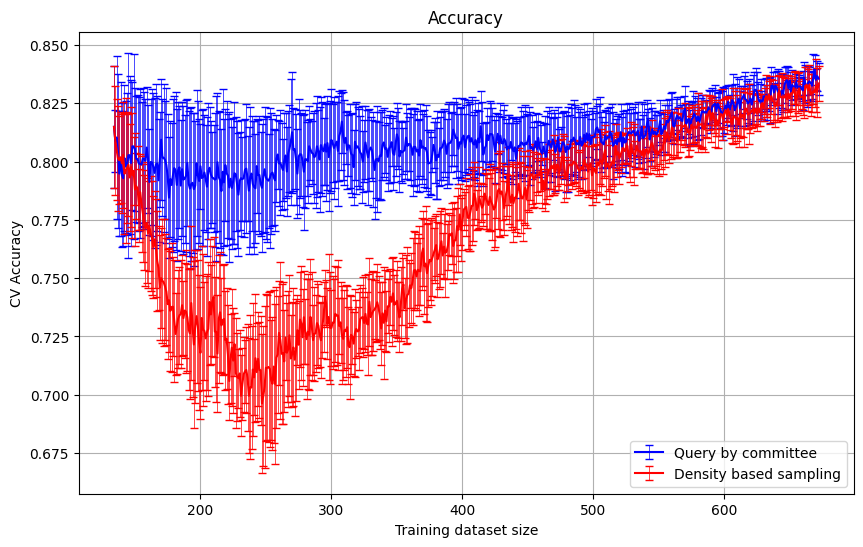

In [30]:
# plot the figure for the training set accuray visualization
plt.figure(figsize=(10, 6))
plt.errorbar(range(int(0.2 * len(X)), int(0.2 * len(X)) + len(train_mean)), train_mean, yerr=train_std, label='Query by committee', 
            color='b', capsize=3, elinewidth=0.5, capthick=1)

plt.errorbar(range(int(0.2 * len(X)), int(0.2 * len(X)) + len(train_mean_1)), train_mean_1, yerr=train_std_1, label='Density based sampling', 
            color='r', capsize=3, elinewidth=0.5, capthick=1)

plt.xlabel('Training dataset size')
plt.ylabel('CV Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## (d) Using exercise 2 of homework1 code to run passive learning and active learning of uncertaininty sampling


In [33]:
# define the passive learning method, each time we add 1 sample randomly.
class passive_learning:
    # def __init__(self):
    
    def select_instance(self, pool_X):
        # randomly select one
        return np.random.choice(len(pool_X))
    


# active learning with uncertainty sampling
class active_learning:
    # def __init__(self):
    def select_instance(self, pool_X, model):
        # use entropy-based uncertainty
        probs = model.predict_proba(pool_X)
        uncertainty = -np.sum(probs * np.log(probs + 1e-10), axis=1)  # Entropy-based uncertainty
        return np.argmax(uncertainty)



# update the run_simulation function
def run_simulation(X, y, method, seeds=SEED_LIST):
    seed_scores = []
    # run 10 seeds
    for seed in seeds:
        train_idx, pool_idx = initialize_data(seed, 0.2) # 20% of data as initial training set
        train_X, train_y = X[train_idx], y[train_idx]
        pool_X, pool_y = X[pool_idx], y[pool_idx]
        # do model prediction
        forest = RandomForestClassifier(n_estimators=50, random_state=seed)
        forest.fit(train_X, train_y)
        cv_scores = []
        
        for _ in range(len(pool_X)):

            score = evaluate_model(train_X, train_y, forest)
            cv_scores.append(score)
            
            if method == "QBC":
                query = QueryByCommittee(forest)
                query_idx = query.select_instance(pool_X)

            # update another query method - uncertainty sampling.
            elif method == 'active':
                query = active_learning()
                query_idx = query.select_instance(pool_X, forest)

            elif method == 'passive':
                query = passive_learning()
                query_idx = query.select_instance(pool_X)

            else:
                query = DensityBasedSampling()
                query_idx = query.select_instance(pool_X, forest)
            
            train_X = np.vstack([train_X, pool_X[query_idx]])
            train_y = np.append(train_y, pool_y[query_idx])
            pool_X = np.delete(pool_X, query_idx, axis=0)
            pool_y = np.delete(pool_y, query_idx, axis=0)
            
            forest.fit(train_X, train_y)  # Retrain the random forest with the new data point
        seed_scores.append(cv_scores)
        print(f"This is seed {seed}.")
    seed_scores = np.array(seed_scores)
    mean = np.mean(seed_scores, axis=0)
    std = np.std(seed_scores, axis=0)
    
    return mean, std


In [34]:
train_mean_2, train_std_2 = run_simulation(X, y, 'active')

This is seed 0.
This is seed 1.
This is seed 2.
This is seed 3.
This is seed 4.
This is seed 5.
This is seed 6.
This is seed 7.
This is seed 8.
This is seed 9.


In [35]:
train_mean_3, train_std_3 = run_simulation(X, y, 'passive')

This is seed 0.
This is seed 1.
This is seed 2.
This is seed 3.
This is seed 4.
This is seed 5.
This is seed 6.
This is seed 7.
This is seed 8.
This is seed 9.


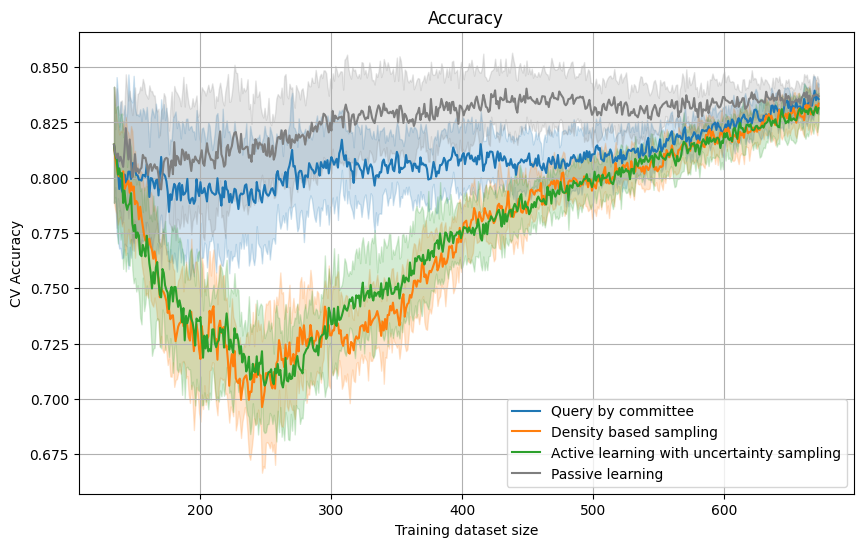

In [51]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define the x-axis range for all plots
x_values = range(int(0.2 * len(X)), int(0.2 * len(X)) + len(train_mean))

# Plot for Query by committee
plt.plot(x_values, train_mean, label='Query by committee', color='#1f77b4')
plt.fill_between(x_values, train_mean - train_std, train_mean + train_std, color='#1f77b4', alpha=0.2)

# Plot for Density based sampling
plt.plot(x_values, train_mean_1, label='Density based sampling', color='#ff7f0e')
plt.fill_between(x_values, train_mean_1 - train_std_1, train_mean_1 + train_std_1, color='#ff7f0e', alpha=0.2)

# Plot for Active learning with uncertainty sampling
plt.plot(x_values, train_mean_2, label='Active learning with uncertainty sampling', color='#2ca02c')
plt.fill_between(x_values, train_mean_2 - train_std_2, train_mean_2 + train_std_2, color='#2ca02c', alpha=0.2)

# Plot for Passive learning
plt.plot(x_values, train_mean_3, label='Passive learning', color='#7f7f7f')
plt.fill_between(x_values, train_mean_3 - train_std_3, train_mean_3 + train_std_3, color='#7f7f7f', alpha=0.2)

# Add labels, title, and legend
plt.xlabel('Training dataset size')
plt.ylabel('CV Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# store the data
variables = [train_mean, train_mean_1, train_mean_2, train_mean_3, 
             train_std, train_std_1, train_std_2, train_std_3]
var_names = ["train_mean", "train_mean_1", "train_mean_2", "train_mean_3",
             "train_std", "train_std_1", "train_std_2", "train_std_3"]
exe1_data = pd.DataFrame({name: var for name, var in zip(var_names, variables)})


In [48]:
exe1_data.to_csv("exe1_data.csv", index=False, header=True)